In [14]:
%load_ext autoreload
%autoreload 2

In [1]:
from templates import *

In [2]:
device = 'cuda:0'
# conf = ffhq128_autoenc_72M()
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
# state = torch.load(f'/home/coolboy/wwh/diffusion-autoencoders-main/output/latentweight/128_bs128_latent8192/epoch_240_ckpt.pth', map_location='cpu')
# model.load_state_dict(state, strict=False)
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


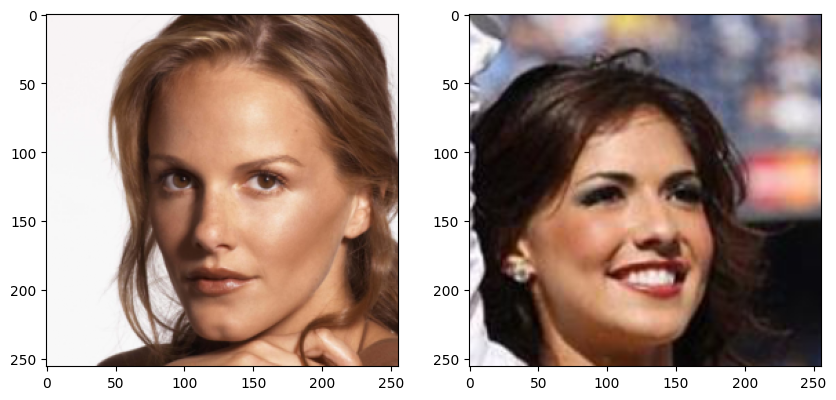

In [3]:
import matplotlib.pyplot as plt
data = ImageDataset('imgs_render', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch1 = data[0]['img'][None]
batch2 = data[1]['img'][None]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch1 + 1) / 2
ax[0].imshow(batch1[0].permute([1, 2, 0]) / 2 + 0.5)
ax[1].imshow(batch2[0].permute([1, 2, 0]) / 2 + 0.5)

# Benign Classifier

In [6]:
from detector.xception_net import Xception_Net
from torchvision import transforms, datasets
from efficientnet_pytorch import EfficientNet
import torchvision
from torchvision import datasets, transforms, models
import torch
device = 'cuda:0'
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225] 
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}
dir_path = '/home/coolboy/wwh/Data/val'
batch_size = 128
test_dataset = datasets.ImageFolder(dir_path, data_transforms['test'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True, num_workers=0, pin_memory=True)
dataset_size = len(test_dataset)
print('size: {}'.format(dataset_size))
print('Class to index mapping:', test_dataset.class_to_idx)
# classifier = Xception_Net()
# classifier = EfficientNet.from_name('efficientnet-b7').to(device)
classifier = torchvision.models.resnet50(pretrained=False).to(device)
num_ftrs = classifier.fc.in_features
classifier.fc = nn.Linear(num_ftrs, 2)  # 将最后一层改为输出2类

weightpath = '/home/coolboy/wwh/diffusion-autoencoders-main/weight/effnet_model_best_0.9995_epoch3.pt'

check = torch.load(weightpath)
classifier.load_state_dict(check)
classifier = classifier.cuda()
classifier.eval()
correct, TP, TN, FP, FN = 0, 0, 0, 0, 0
total_tested = 0
total_correct = 0
interrupt = 0
for images, labels in test_loader:
    interrupt += 1
    if interrupt == 100:
        break
    inputs = images.to(device)
    labels = labels.to(device)
    # print('labels', labels)
    with torch.no_grad():
        output = classifier(inputs)

    _, prediction = torch.max(output, 1)
    total_tested += labels.size(0)
    total_correct += torch.sum(prediction == labels).item()
    # print('pred', prediction)
    correct = torch.sum((prediction.detach()) == labels.detach().to(torch.float32))
    TP += torch.sum((prediction == 1) & (labels == 1))
    TN += torch.sum((prediction == 0) & (labels == 0))
    FP += torch.sum((prediction == 1) & (labels == 0))
    FN += torch.sum((prediction == 0) & (labels == 1))

    
    precision = TP.float() / (TP + FP).float()
    recall = TP.float() / (TP + FN).float()
    f1_score = 2 * (precision * recall) / (precision + recall)

    print('Testing {}:[{}/{} ({:.0f}%)] Acc: {}%'.format(interrupt, interrupt*batch_size, dataset_size,
                                                        100. * interrupt*batch_size / dataset_size,
                                                        correct / (batch_size) * 100))

print('True Positives: {}, True Negatives: {}, False Positives: {}, False Negatives: {}'.format(TP, TN, FP, FN))
print('Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}'.format(precision, recall, f1_score))
avg_accuracy = total_correct / total_tested
print('Average Accuracy: {:.2f}%'.format(avg_accuracy * 100))

size: 2000
Class to index mapping: {'Fake': 0, 'Real': 1}
Testing 1:[128/2000 (6%)] Acc: 100.0%
Testing 2:[256/2000 (13%)] Acc: 100.0%
Testing 3:[384/2000 (19%)] Acc: 100.0%
Testing 4:[512/2000 (26%)] Acc: 100.0%
Testing 5:[640/2000 (32%)] Acc: 100.0%
Testing 6:[768/2000 (38%)] Acc: 100.0%
Testing 7:[896/2000 (45%)] Acc: 100.0%
Testing 8:[1024/2000 (51%)] Acc: 100.0%
Testing 9:[1152/2000 (58%)] Acc: 100.0%
Testing 10:[1280/2000 (64%)] Acc: 100.0%
Testing 11:[1408/2000 (70%)] Acc: 99.21875%
Testing 12:[1536/2000 (77%)] Acc: 100.0%
Testing 13:[1664/2000 (83%)] Acc: 100.0%
Testing 14:[1792/2000 (90%)] Acc: 100.0%


KeyboardInterrupt: 

In [ ]:
from detector.xception_net import Xception_Net
from torchvision import transforms, datasets
import torch
device = 'cuda:0'
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225] 
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}
dir_path = '/home/coolboy/wwh/diffusion-autoencoders-main/imgs_align'
batch_size = 16
test_dataset = datasets.ImageFolder(dir_path, data_transforms['test'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, num_workers=0, pin_memory=True)
dataset_size = len(test_dataset)
print('size: {}'.format(dataset_size))
print('Class to index mapping:', test_dataset.class_to_idx)
classifier = Xception_Net()
weightpath = '/home/coolboy/wwh/diffusion-autoencoders-main/weight/xcep_9375.pt'
check = torch.load(weightpath)
classifier.load_state_dict(check)
classifier = classifier.cuda()
classifier.eval()

for images, labels in test_loader:
   
    inputs = images.to(device)
    labels = labels.to(device)
    print('labels', labels)
    with torch.no_grad():
        output = classifier(inputs)

    _, prediction = torch.max(output, 1)
    print('pred', prediction)

size: 2
Class to index mapping: {'Fake': 0, 'Real': 1}
labels tensor([0, 1], device='cuda:0')
pred tensor([0, 1], device='cuda:0')


# Encode

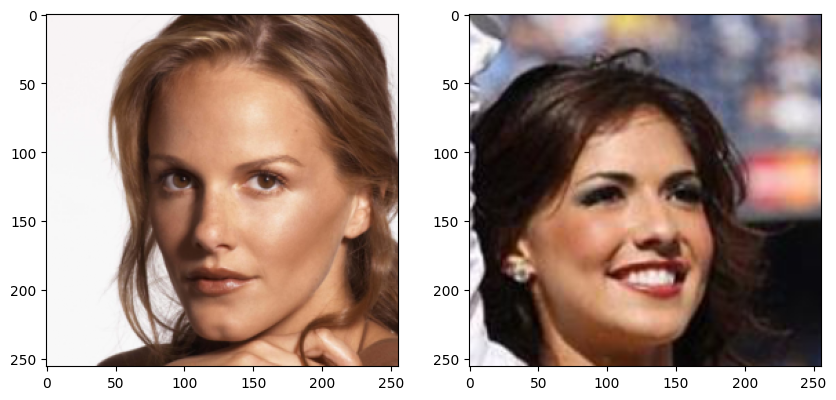

In [4]:
import matplotlib.pyplot as plt
from templates import *
data1 = ImageDataset('imgs_render/Fake', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
data2 = ImageDataset('imgs_render/Real', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch1 = data1[0]['img'][None]
batch2 = data2[0]['img'][None]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch1 + 1) / 2
ax[0].imshow(batch1[0].permute([1, 2, 0]) / 2 + 0.5)
ax[1].imshow(batch2[0].permute([1, 2, 0]) / 2 + 0.5)

In [ ]:
cond1 = model.encode(batch1.to(device))
# cond2 = model.encode(batch2.to(device))
# xT_1 = model.encode_stochastic(batch1.to(device), cond1, T=100)
# xT_2 = model.encode_stochastic(batch2.to(device), (cond1 + cond2) / 2, T=100)
torch.save(cond1,'/home/coolboy/wwh/diffusion-autoencoders-main/StyleGAN_weight/latent_code/num_51_latent.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


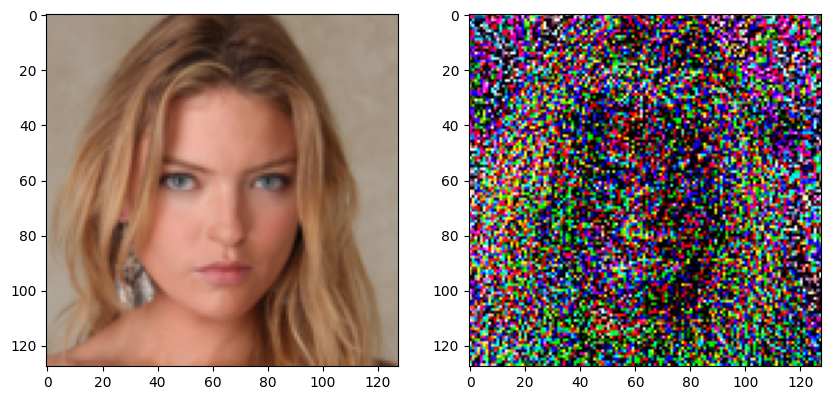

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch2 + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT_2[0].permute(1, 2, 0).cpu())

# Encode True Image average style

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [3]:
from templates import *

def process_and_save_conditions(dataset_path, save_path, model, device):
    # 加载数据
    dataset = ImageDataset(dataset_path, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)

    # 保存每张图像的编码到列表中
    encoded_conditions = []
    total_images = len(dataset)

    for idx in range(total_images):
        if idx % 10000 == 0:
            print(idx)
        image_batch = dataset[idx]['img'][None]
        condition = model.encode(image_batch.to(device))
        encoded_conditions.append(condition)

    torch.save(encoded_conditions, save_path)

# 处理伪造数据
process_and_save_conditions('/home/coolboy/wwh/256-FFHQ-StyleGAN/train/Real', '/home/coolboy/wwh/diffusion-autoencoders-main/256_weight_FFHQ_stylegan/latent_code/reallist.pth', model, device)

# 处理真实数据



0
10000
20000
30000
40000
50000


In [4]:
from templates import *
from PIL import Image
import torchvision.transforms as transforms

def process_and_save_conditions(dataset_path, save_path, model, device, save_sample_interval=5, save_dir="saved_samples"):
    # 加载数据
    dataset = ImageDataset(dataset_path, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)

    # 创建保存图像的目录
    os.makedirs(save_dir, exist_ok=True)

    # 将Tensor转换为PIL图像
    to_pil_image = transforms.ToPILImage()

    # 保存每张图像的编码到列表中
    encoded_conditions = []
    total_images = len(dataset)

    for idx in range(total_images):
        if idx % 1000 == 0:
            print(idx)
        
        image_batch = dataset[idx]['img'][None]
        condition = model.encode(image_batch.to(device))
        encoded_conditions.append(condition)
        
        # 每隔 save_sample_interval 保存一张图像
        if idx % save_sample_interval == 0:
            image_path = os.path.join(save_dir, f"sample_{idx}.jpg")
            image = to_pil_image(image_batch.squeeze(0))
            image.save(image_path)

    torch.save(encoded_conditions, save_path)

# 处理伪造数据
process_and_save_conditions('/home/coolboy/wwh/CelebA-HQ_256_StyleGAN/train/Fake', '/home/coolboy/wwh/diffusion-autoencoders-main/StyleGAN_weight/celebAHQ_fake_3w.pth', model, device)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


In [4]:
process_and_save_conditions('/home/coolboy/wwh/256-FFHQ-StyleGAN/train/Fake', '/home/coolboy/wwh/diffusion-autoencoders-main/256_weight_FFHQ_stylegan/latent_code/fakelist.pth', model, device)

0
10000
20000
30000
40000
50000


In [6]:
# 20k
"""
l1 norm
fake mean - real mean = 7.5928354263
fake conds - real mean = 36.5600471497
fake conds - fake mean = 35.7334785461
real conds - real mean = 36.5325317383
real conds - fake mean = 37.3595848083
l2 norm
fake mean - real mean = 0.4252
fake conds - real mean = 2.0797
fake conds - fake mean = 2.0355
real conds - real mean = 2.0793
real conds - fake mean = 2.1232
"""
# 180k
"""
l1 norm
fake mean - real mean = 7.5928354263
fake conds - real mean = 36.5600471497
fake conds - fake mean = 35.7334785461
real conds - real mean = 36.5325317383
real conds - fake mean = 37.3595848083
l2 norm
fake mean - real mean = 0.3681
fake conds - real mean = 2.0797
fake conds - fake mean = 2.0355
real conds - real mean = 2.0793
real conds - fake mean = 2.1232
"""

'\nl1 norm\nfake mean - real mean = 7.5928354263\nfake conds - real mean = 36.5600471497\nfake conds - fake mean = 35.7334785461\nreal conds - real mean = 36.5325317383\nreal conds - fake mean = 37.3595848083\nl2 norm\nfake mean - real mean = 0.4252\nfake conds - real mean = 2.0797\nfake conds - fake mean = 2.0355\nreal conds - real mean = 2.0793\nreal conds - fake mean = 2.1232\n'

In [5]:
fake_loaded_cond_list = torch.load('/home/coolboy/wwh/diffusion-autoencoders-main/256_weight_FFHQ_stylegan/latent_code/fakelist.pth')
# 堆叠cond_list以形成一个2D张量
fake_stacked_conds = torch.stack(fake_loaded_cond_list)
fake_average_vector = fake_stacked_conds.mean(dim=0)

real_loaded_cond_list = torch.load('/home/coolboy/wwh/diffusion-autoencoders-main/256_weight_FFHQ_stylegan/latent_code/reallist.pth')
# 堆叠cond_list以形成一个2D张量
real_stacked_conds = torch.stack(real_loaded_cond_list)
real_average_vector = real_stacked_conds.mean(dim=0)
# 计算fake_average_vector和real_average_vector之间的距离

print(fake_average_vector.shape)
distance_between_averages = torch.norm(fake_average_vector - real_average_vector, dim = 1)
print(distance_between_averages.shape)
print("Distance between fake_average_vector and real_average_vector:", distance_between_averages)

torch.save(fake_average_vector, '/home/coolboy/wwh/diffusion-autoencoders-main/256_weight_FFHQ_stylegan/latent_code/fake_mean.pth')
torch.save(real_average_vector, '/home/coolboy/wwh/diffusion-autoencoders-main/256_weight_FFHQ_stylegan/latent_code/real_mean.pth')

torch.Size([1, 512])
torch.Size([1])
Distance between fake_average_vector and real_average_vector: tensor([0.5948], device='cuda:0')


In [6]:
fake_average_vector = torch.load('weight/fake_mean.pth')
real_average_vector = torch.load('weight/real_mean.pth')

In [20]:
# fake_average_vector.shape
real_average_vector.shape

torch.Size([1, 512])

In [23]:
# 计算l2
fake_loaded_cond_list = torch.load('/home/coolboy/wwh/diffusion-autoencoders-main/weight/fake_conds180k.pth')
fake_stacked_conds = torch.stack(fake_loaded_cond_list)
# fake_average_vector = fake_stacked_conds.mean(dim=0)
# print(fake_stacked_conds.shape) # torch.Size([10000, 1, 512])
# print(fake_average_vector.shape) # torch.Size([1, 512])

real_loaded_cond_list = torch.load('/home/coolboy/wwh/diffusion-autoencoders-main/weight/real_conds180k.pth')
real_stacked_conds = torch.stack(real_loaded_cond_list)
# real_average_vector = real_stacked_conds.mean(dim=0)
# print(real_stacked_conds.shape) # torch.Size([10000, 1, 512])
# print(real_average_vector.shape) # torch.Size([1, 512])


# Compute L2 distances for each instance in fake_stacked_conds to the real_average_vector
distances = torch.norm(real_stacked_conds.squeeze() - real_average_vector.squeeze(), dim=1)
test = fake_stacked_conds.squeeze()
print('test shape', test.shape)
print(distances.shape) # Should print torch.Size([10000])

# Compute the average distance
average_distance = distances.mean()

print("Average distance to the average vector:", average_distance)



KeyboardInterrupt: 

In [ ]:
# 计算l1
fake_loaded_cond_list = torch.load('/home/coolboy/wwh/diffusion-autoencoders-main/weight/fake_conds.pth')
fake_stacked_conds = torch.stack(fake_loaded_cond_list)
fake_average_vector = fake_stacked_conds.mean(dim=0)
print(fake_stacked_conds.shape) # torch.Size([10000, 1, 512])
print(fake_average_vector.shape) # torch.Size([1, 512])

real_loaded_cond_list = torch.load('/home/coolboy/wwh/diffusion-autoencoders-main/weight/real_conds.pth')
real_stacked_conds = torch.stack(real_loaded_cond_list)
real_average_vector = real_stacked_conds.mean(dim=0)
print(real_stacked_conds.shape) # torch.Size([10000, 1, 512])
print(real_average_vector.shape) # torch.Size([1, 512])

# 计算每一个实例与real_average_vector的L1距离
l1_distances = torch.abs(fake_stacked_conds - real_average_vector).sum(dim=2).squeeze()
print(l1_distances.shape) # torch.Size([10000])

# 计算整体的平均L1距离
average_l1_distance = l1_distances.mean()

print("Average L1 distance to the real average vector: {:.10f}".format(average_l1_distance))

# 计算fake_average_vector与real_average_vector之间的L1距离
l1_distance = torch.abs(fake_average_vector - real_average_vector).sum(dim=1).item()

print("L1 distance between fake_average_vector and real_average_vector: {:.10f}".format(l1_distance))



torch.Size([10000, 1, 512])
torch.Size([1, 512])
torch.Size([10000, 1, 512])
torch.Size([1, 512])
torch.Size([10000])
Average L1 distance to the real average vector: 36.5600471497
L1 distance between fake_average_vector and real_average_vector: 7.5928354263


# Decode

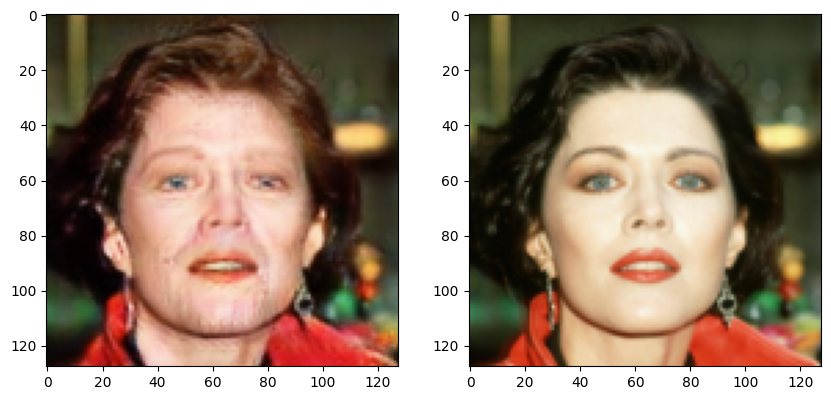

In [3]:
import matplotlib.pyplot as plt
from templates import *
data1 = ImageDataset('imgs_align/Fake', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
data2 = ImageDataset('imgs_align/Real', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch1 = data1[0]['img'][None]
batch2 = data2[0]['img'][None]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch1 + 1) / 2
ax[0].imshow(batch1[0].permute([1, 2, 0]) / 2 + 0.5)
ax[1].imshow(batch2[0].permute([1, 2, 0]) / 2 + 0.5)

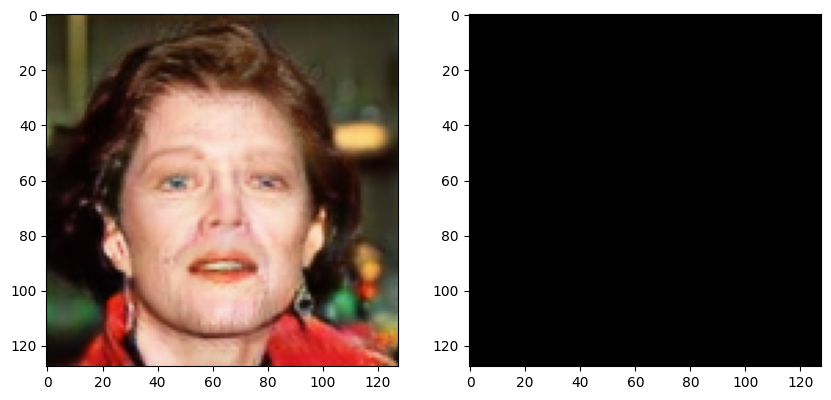

In [4]:
import matplotlib.pyplot as plt
cond1 = model.encode(batch1.to(device))
cond2 = model.encode(batch2.to(device))
device = torch.device("cuda:0")  # or whichever device you prefer

# fake_average_vector = fake_average_vector.to(device)
# real_average_vector = real_average_vector.to(device)
xT_1 = model.encode_stochastic(batch1.to(device), cond1, T=100)
# xT_2 = model.encode_stochastic(batch2.to(device), cond2, T=100)
xT_1 = xT_1.to(device)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch1 + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT_1[0].permute(1, 2, 0).cpu())

In [9]:
cond1

tensor([[-0.2190, -0.3993,  0.1681,  ...,  0.2059, -0.3945,  0.2154]],
       device='cuda:0')

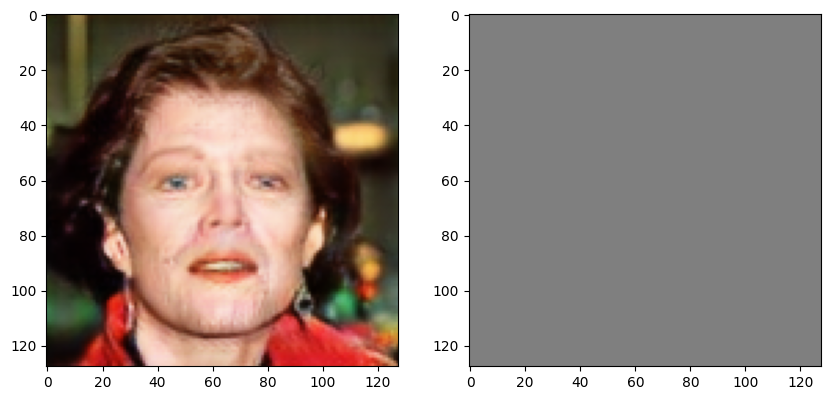

In [5]:
# Fake -> Real
from torchvision.utils import save_image

a = 0.6
b = 0.4
combine_vector = a * cond1 + b * cond2

pred = model.render(xT_1, combine_vector, T=100)
# pred = model.render(xT, cond1, T=100)
# pred = model.render(xT, cond2, T=100)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch1 + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu())
# # 保存整个plt输出
# fig.savefig("/home/coolboy/wwh/diffusion-autoencoders-main/imgs_render/Fake/complete_output_image.png")

# 仅保存pred图像
save_image(pred[0], f"/home/coolboy/wwh/diffusion-autoencoders-main/imgs_render/Real/pred1.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


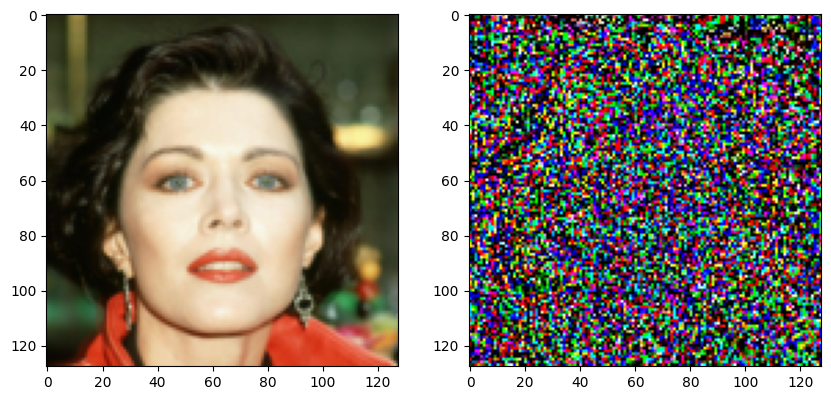

In [49]:
# real -> fake
import matplotlib.pyplot as plt
# cond1 = model.encode(batch1.to(device))
cond2 = model.encode(batch2.to(device))
device = torch.device("cuda:0")  # or whichever device you prefer
xT_2 = model.encode_stochastic(batch2.to(device), cond2, T=100)
xT_2 = xT_2.to(device)
fake_average_vector = fake_average_vector.to(device)
real_average_vector = real_average_vector.to(device)
# xT_2 = model.encode_stochastic(batch2.to(device), (cond1 + cond2) / 2, T=100)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch2 + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT_2[0].permute(1, 2, 0).cpu())

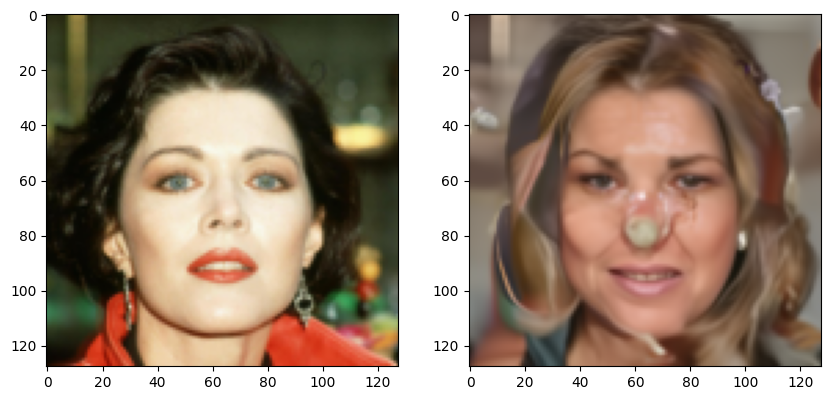

In [62]:
# Fake -> Real
from torchvision.utils import save_image

a = 0
b = 1
combine_vector = a * cond1 + b * fake_average_vector

pred = model.render(xT_2, combine_vector, T=100)
# pred = model.render(xT, cond1, T=100)
# pred = model.render(xT, cond2, T=100)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch2 + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu())
# # 保存整个plt输出
# fig.savefig("/home/coolboy/wwh/diffusion-autoencoders-main/imgs_render/Fake/complete_output_image.png")

# 仅保存pred图像
save_image(pred[0], f"/home/coolboy/wwh/diffusion-autoencoders-main/imgs_render/Real/pred1.png")

In [8]:
from detector.xception_net import Xception_Net
from torchvision import transforms, datasets
import torch
device = 'cuda:0'
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225] 
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}
dir_path = '/home/coolboy/wwh/diffusion-autoencoders-main/imgs_render'
batch_size = 16
test_dataset = datasets.ImageFolder(dir_path, data_transforms['test'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, num_workers=0, pin_memory=True)
dataset_size = len(test_dataset)
print('size: {}'.format(dataset_size))
print('Class to index mapping:', test_dataset.class_to_idx)
classifier = Xception_Net()
# classifier = EfficientNet.from_name('efficientnet-b7').to(device)
classifier = torchvision.models.resnet50(pretrained=False).to(device)
num_ftrs = classifier.fc.in_features
classifier.fc = nn.Linear(num_ftrs, 2)  # 将最后一层改为输出2类
weightpath = '/home/coolboy/wwh/diffusion-autoencoders-main/weight/ResNet_model_best_0.9845_epoch14.pt'

check = torch.load(weightpath)
classifier.load_state_dict(check)
classifier = classifier.cuda()
classifier.eval()

for images, labels in test_loader:
   
    inputs = images.to(device)
    labels = labels.to(device)
    print('labels', labels)
    with torch.no_grad():
        output = classifier(inputs)
        print('output', output)

    _, prediction = torch.max(output, 1)
    print('pred', prediction)

size: 6
Class to index mapping: {'Fake': 0, 'Real': 1}


/home/coolboy/anaconda3/envs/effvit/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/coolboy/anaconda3/envs/effvit/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


labels tensor([0, 0, 0, 0, 0, 1], device='cuda:0')
output tensor([[ 4.4620, -5.2736],
        [ 3.3274, -4.5862],
        [ 4.3157, -4.9816],
        [ 3.7039, -4.4575],
        [ 2.9889, -4.0250],
        [-0.5630, -0.2859]], device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 1], device='cuda:0')
